In [86]:
def evaluate_energy_with_cutting(subcircuits_l: list[QuantumCircuit], subobservables, parameters: np.ndarray, shots, num_samples, backend='simulation'):
    # Transform the numpy array into a list
    parameters_list = list(parameters)

    try:
        # Copy the subcircuits to avoid modifying the original
        # Create a dictionary with the same keys as self.subcircuits
        subcircuits = dict.fromkeys(subcircuits_l.keys())

        # Assign the parameters to the subcircuits
        # First, split the parameters based on how many parameters each subcircuit has
        subcircuit_parameters = []
        for subcircuit_key in subcircuits.keys():
            subcircuit_parameters.append(parameters_list[0:len(subcircuits_l[subcircuit_key].parameters)])
            parameters_list = parameters_list[len(subcircuits_l[subcircuit_key].parameters):]

        # Then, assign the parameters to the subcircuits
        for i, subcircuit_key in enumerate(subcircuits.keys()):
            subcircuits[subcircuit_key] = subcircuits_l[subcircuit_key].assign_parameters(subcircuit_parameters[i], inplace=False)

        # Execute the circuits
        if backend == 'simulation':
            quasi_dists, coefficients = execute_simulation(subcircuits, subobservables, shots=shots, samples=num_samples)
            # Reconstruct the expectation values
            simulated_expvals = reconstruct_expectation_values(quasi_dists, coefficients, subobservables)
        elif backend == 'azure':
            job_list, qpd_list, coefficients, subexperiments = azure_queue_experiments(
                circuits=subcircuits,
                subobservables=subobservables,
                num_samples=8,  # 8 unique samples to get some statistics
                backend=self.azure_backend,
                shots=128  # Balance of cost and accuracy
            )
            experiment_results = get_experiment_results_from_jobs(job_list, qpd_list, coefficients)
            simulated_expvals = reconstruct_expectation_values(*experiment_results, subobservables)

    except Exception as exc:
        raise AlgorithmError("The primitive job to evaluate the energy failed!") from exc

    energy = 0

    for i in range(0, len(operator)):
        energy += operator[i].coeffs[0].real * simulated_expvals[i]

    if self.callback is not None:
        eval_count += 1
        self.callback(eval_count, parameters, energy, {'': None})

    return energy

In [87]:
'''
For QFT, SPM, ADD, QAOA:
Do circuit sizes in Table 1 of paper
If possible, push for larger
Collect: 
# subcircuits
# wire cuts
# gate cuts
depth of pre-cut circuit
depth of subcircuits
time to find optimal solution
time to reconstruct in postprocessing step
Error
Relative error
'''

from qiskit.circuit import QuantumCircuit
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import execute_simulation
from circuit_knitting.cutting.cutting_reconstruction import reconstruct_expectation_values
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import exact_observables
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import compare_results
import time

def benchmark(circuit: QuantumCircuit, observables: list[str], parameters, max_subcircuit_width=2, max_cuts=4, num_subcircuits=[2], get_errors=False):
    # Cut the circuits
    opt_s = time.time()
    subcircuits, subobservables, wire_cuts, gate_cuts = cut_wires_and_gates_to_subcircuits(
        circuit=circuit,
        observables=[str(observable) for observable in observables],
        method='automatic',
        max_subcircuit_width=max_subcircuit_width,
        max_cuts=max_cuts,
        num_subcircuits=num_subcircuits,
        model='gurobi',
    )
    opt_time = time.time() - opt_s
    
    # Execute the subcircuits
    recon_s = time.time()
    evaluate_energy_with_cutting(subcircuits, subobservables, parameters, 2**12, 1500)
    #quasi_dists, coefficients = execute_simulation(subcircuits, subobservables)
    #simulation_expvals = reconstruct_expectation_values(quasi_dists, coefficients, subobservables)
    recon_time = time.time() - recon_s
    
    if get_errors:
        ideal_expvals = exact_observables(circuit, observables)
        errors, rel_errors = compare_results(simulation_expvals, ideal_expvals)
    else:
        errors=None
        rel_errors=None
    
    return len(subcircuits), wire_cuts, gate_cuts, circuit.depth(), subcircuits, opt_time, recon_time, errors, rel_errors

In [88]:
from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_vqe import CutVQE
from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_qaoa import CutQAOA

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

algorithm_globals.random_seed = 123
seed = 10598

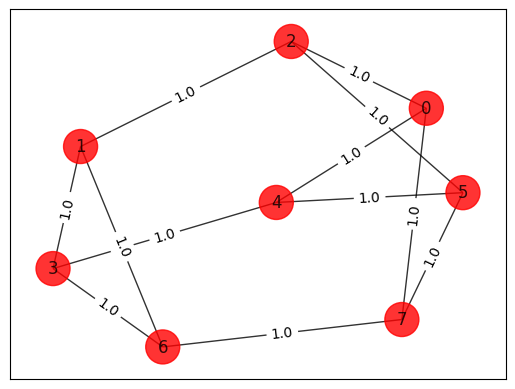

In [89]:
n = 8 # number of nodes in the graph
G = nx.random_regular_graph(3, n)

for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

pos = nx.spring_layout(G)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [90]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
#print(qp.prettyprint())
qubitOp, offset = qp.to_ising()
#print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Ising Hamiltonian:
SparsePauliOp(['IIIIIZIZ', 'IIIZIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IZIIIIZI', 'IIZIIZII', 'IIIZZIII', 'IZIIZIII', 'IIZZIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


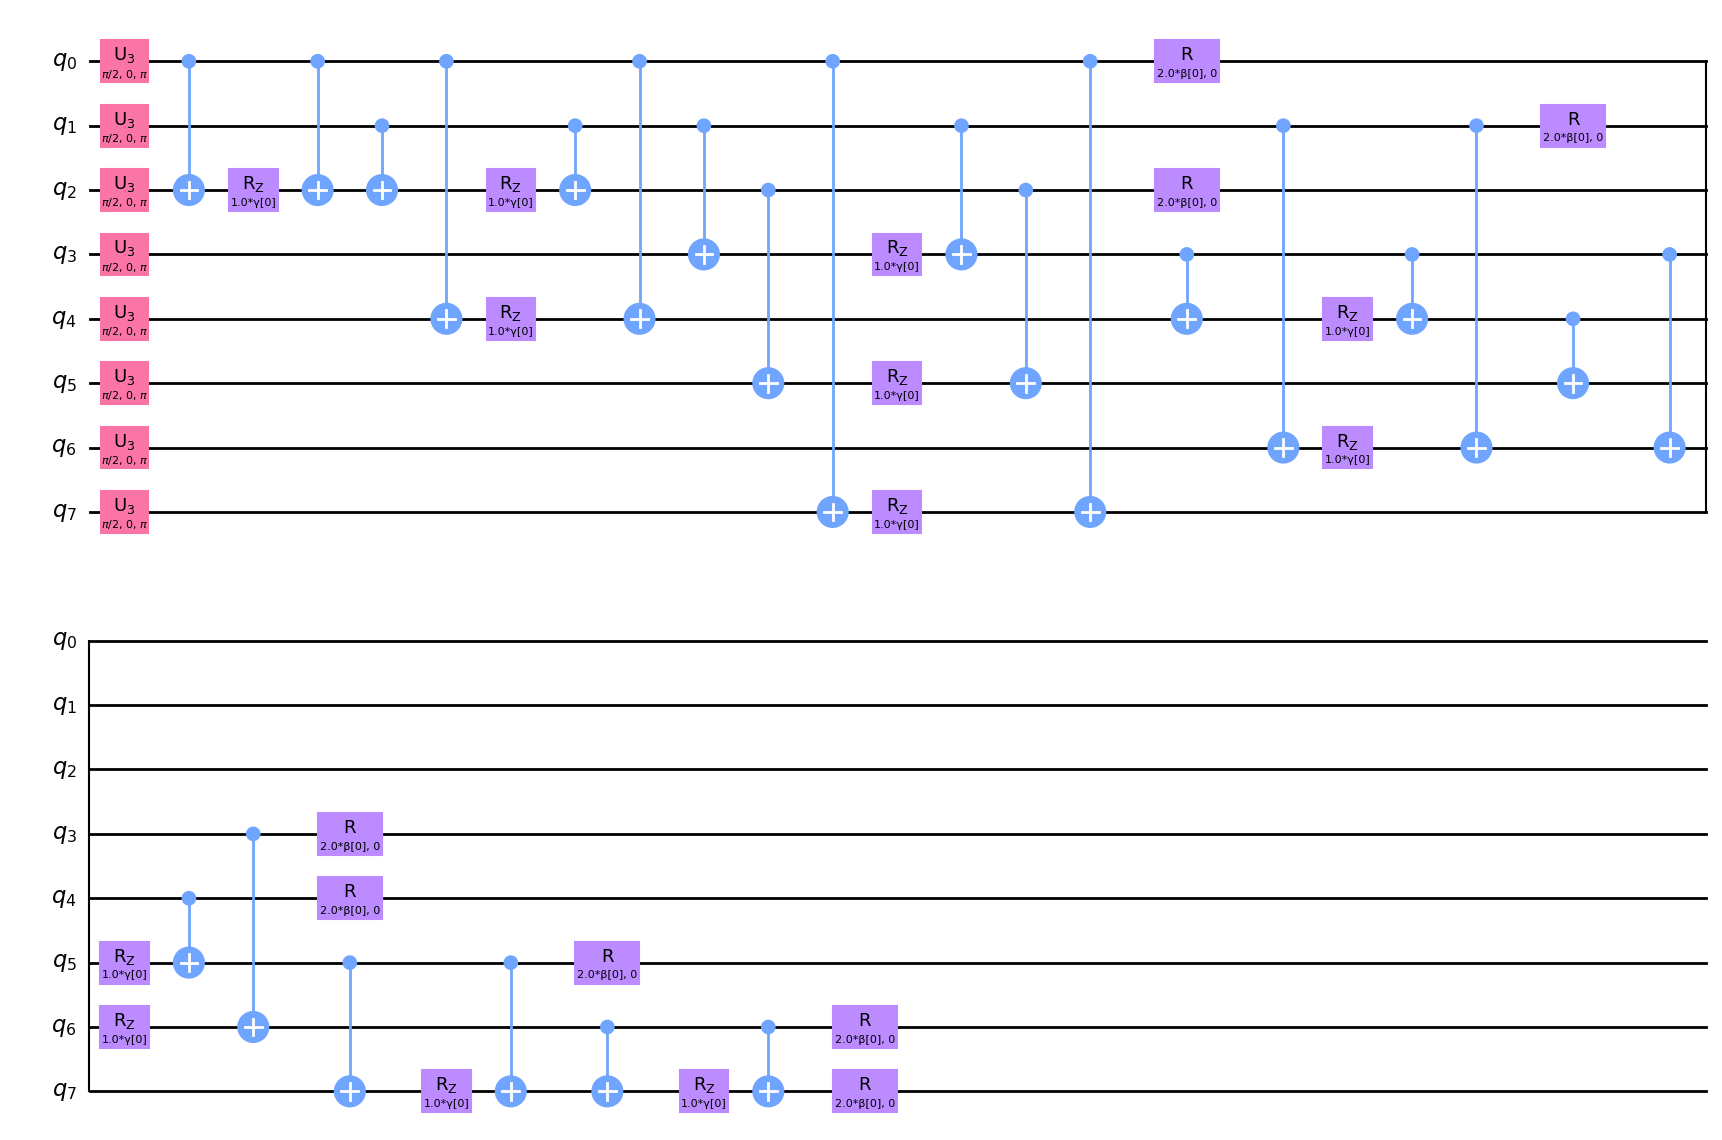

In [94]:
ansatz = QAOAAnsatz(qubitOp, reps=1, flatten=True)
ansatz = ansatz.decompose(reps=2)
ansatz.draw('mpl')

In [91]:
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz

ansatz = QAOAAnsatz(qubitOp, reps=1, flatten=True)
ansatz = ansatz.decompose(reps=2)

# Above we create the QAOAAnsatz, but it is not formatted for the cutter. Below I am swapping out the parameter definitions.

# Get the number of parameters we need
n_param = 0
for d in ansatz.data:
    if len(d.operation.params) > 0 and ('γ' in str(d.operation.params[0]) or 'β' in str(d.operation.params[0])):
        n_param += 1
n_param

#theta = ParameterVector("θ", n_param)
beta = ParameterVector("β", n_param)


# Fix the parameter vectors so we do not have duplicates of parameters
k = 0
for d in ansatz.data:
    if len(d.operation.params) > 0 and ('γ' in str(d.operation.params[0]) or 'β' in str(d.operation.params[0])): 
        if 'β' in str(d.operation.params[0]):
            d.operation.params = [2*beta[k], 0]
        else:
            d.operation.params = [beta[k]]
        k+=1


# Copy to new ansatz so the ansatz.data.parameters only has one parameter vector
new_ansatz = QuantumCircuit(n)

for d in ansatz.data:
    new_ansatz.data.append(d)

#new_ansatz.parameters

/home/vhazoglou/miniconda3/envs/azure-knitting/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


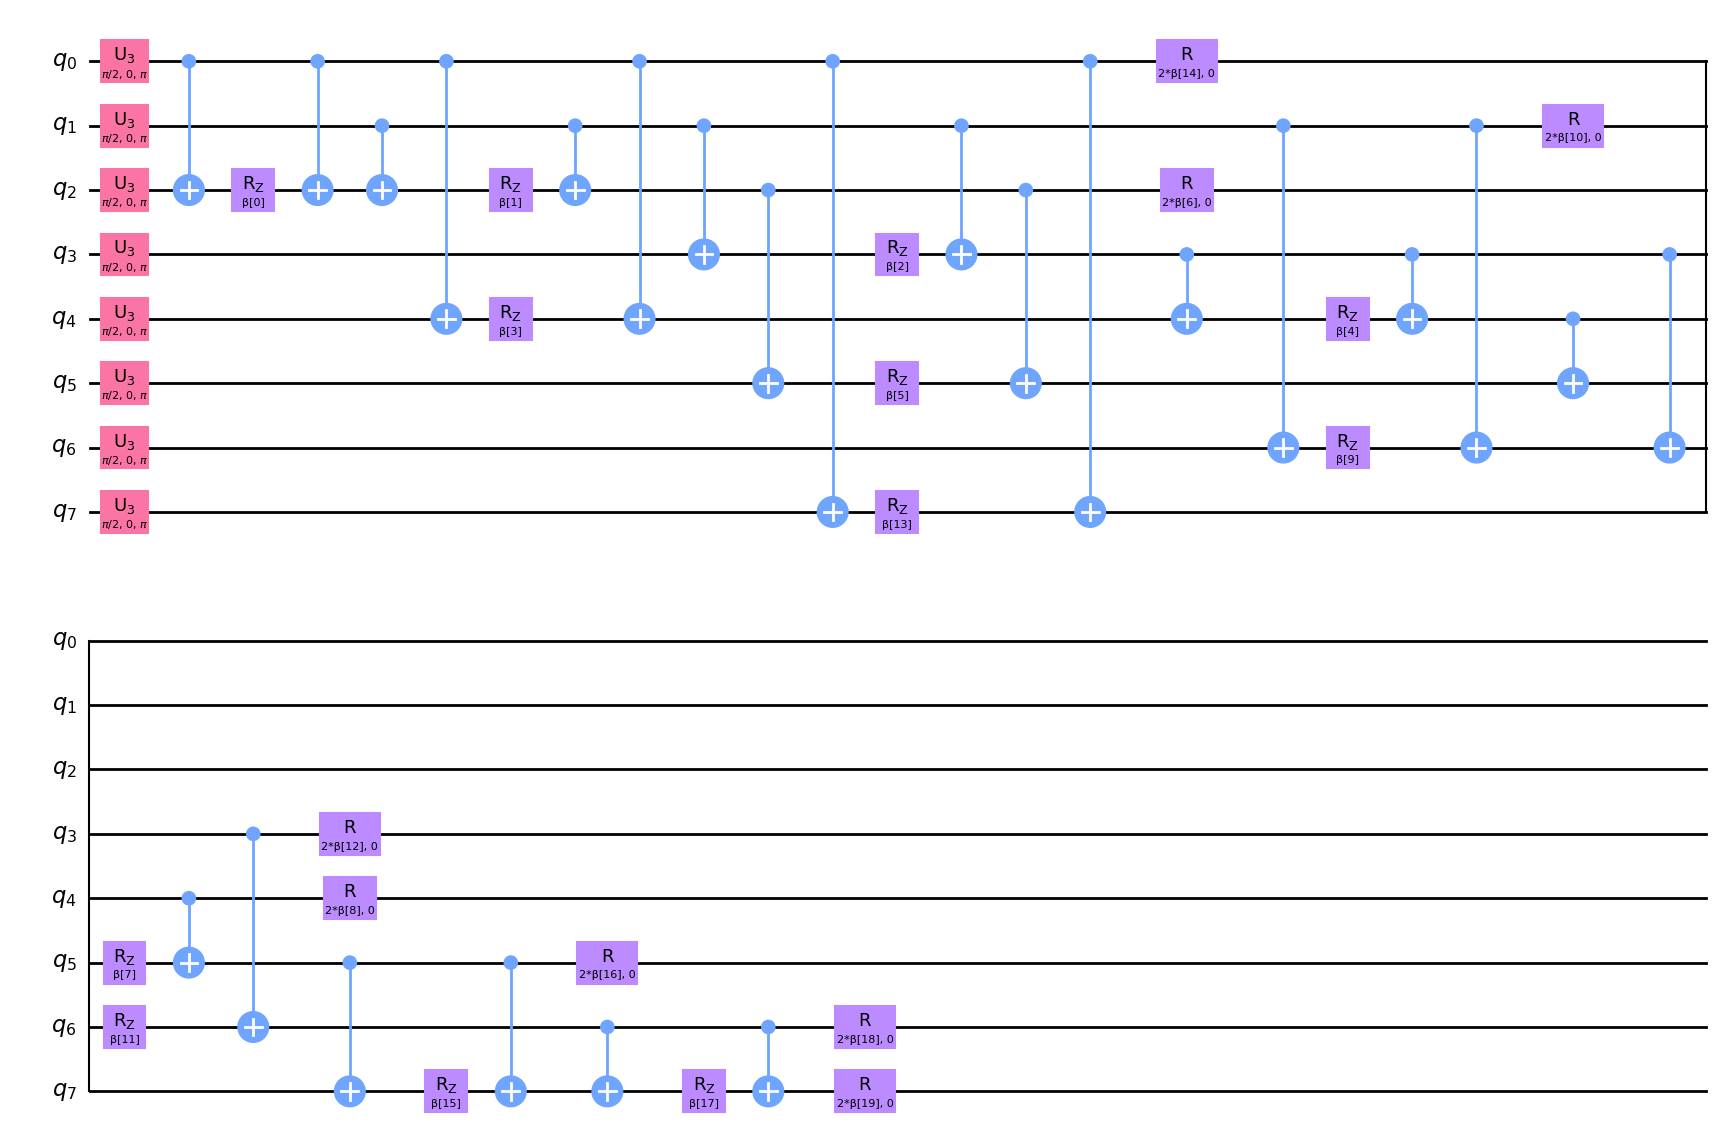

In [93]:
new_ansatz.draw('mpl')

In [95]:
subcircuits, subobservables, wire_cuts, gate_cuts = cut_wires_and_gates_to_subcircuits(
    circuit=new_ansatz,
    observables=[str(observable) for observable in observables],
    method='automatic',
    max_subcircuit_width=n/2,
    max_cuts=15,
    num_subcircuits=[2],
    model='gurobi',
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 617 rows, 263 columns and 2094 nonzeros
Model fingerprint: 0xcce8ffe7
Variable types: 0 continuous, 263 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 78 rows and 66 columns
Presolve time: 0.00s
Presolved: 539 rows, 197 columns, 1749 nonzeros
Variable types: 0 continuous, 197 integer (186 binary)
Found heuristic solution: objective 12.0000000

Root relaxation: objective 3.428571e+00, 216 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds  

In [96]:
n_subcircuits, wire_cuts, gate_cuts, circuit_depth, subcircuits, opt_time, recon_time, errors, rel_errors = benchmark(new_ansatz, observables, beta, n/2, 15, [2])

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 617 rows, 263 columns and 2094 nonzeros
Model fingerprint: 0xcce8ffe7
Variable types: 0 continuous, 263 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 78 rows and 66 columns
Presolve time: 0.00s
Presolved: 539 rows, 197 columns, 1749 nonzeros
Variable types: 0 continuous, 197 integer (186 binary)
Found heuristic solution: objective 12.0000000

Root relaxation: objective 3.428571e+00, 216 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds  

NameError: name 'AlgorithmError' is not defined

In [ ]:
subcircuits[0].draw('mpl')

In [ ]:
print(n_subcircuits, wire_cuts, gate_cuts, circuit_depth)

print(subcircuits[0].depth(), opt_time, recon_time, errors, rel_errors)

In [ ]:
[c.depth() for c in subcircuits.values()]

In [ ]:
print(f'''
Number of subcircuits: {n_subcircuits}
Number of wire cuts: {wire_cuts}
Number of gate cuts: {gate_cuts}
Original circuit depth: {circuit_depth}
Subcircuits' depths:  {[c.depth() for c in subcircuits.values()]}
Optimal solution time: {opt_time} seconds
Reconstruction time: {recon_time} seconds
Error: {errors}
Relative error: {rel_errors}''')